# CAPSTONE 1 PROJECT: FOOD DELIVERY TIME CLUSTERING

Mục tiêu là để hỗ trợ doanh nghiệp tối ưu hóa phân bổ tài xế, quản lý và tuyển chọn nhân sự hiệu quả. Áp dụng phân cụm giúp phân nhóm tài xế dựa trên các đặc trưng hành vi mà không cần nhãn đầu ra (ví dụ: tài xế kỳ cựu hiệu suất cao, tài xế mới, hoặc tài xế ở khu vực giao thông đông đúc). 

**1. IMPORT DATA**

In [20]:
import numpy as np
import seaborn as sns
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [4]:
df= pd.read_csv('D:\HOC DAI HOC\Ky VI\Đề án thực hành\delivery_time_cleaned(1).csv')

In [5]:
df.dtypes

ID                              object
Delivery_person_ID              object
Delivery_person_Age              int64
Delivery_person_Ratings        float64
Order_Date                      object
Weatherconditions               object
Road_traffic_density            object
Vehicle_condition                int64
Type_of_order                   object
Type_of_vehicle                 object
multiple_deliveries              int64
Festival                        object
Area_Type                       object
Time_taken(min)                  int64
City_name                       object
Time_Order_picked_formatted     object
Time_Ordered_formatted          object
Distance_km                    float64
dtype: object

In [6]:
df.describe().T

count       mean       std        min        25%  \
Delivery_person_Age      41901.0  28.009045  5.634575  20.000000  23.000000   
Delivery_person_Ratings  41901.0   4.635307  0.328563   1.000000   4.500000   
Vehicle_condition        41901.0   1.022744  0.838929   0.000000   0.000000   
multiple_deliveries      41901.0   0.750650  0.567051   0.000000   0.000000   
Time_taken(min)          41901.0  26.309133  9.379667  10.000000  19.000000   
Distance_km              41901.0  10.548272  6.106920   0.257182   5.617894   

                               50%        75%        max  
Delivery_person_Age      27.000000  33.000000  39.000000  
Delivery_person_Ratings   4.700000   4.800000   6.000000  
Vehicle_condition         1.000000   2.000000   3.000000  
multiple_deliveries       1.000000   1.000000   3.000000  
Time_taken(min)          26.000000  32.000000  54.000000  
Distance_km               9.730059  14.668513  31.830481

In [7]:
df.describe(exclude=np.number).T

count unique                  top   freq
ID                           41901  41901              0x5fb2       1
Delivery_person_ID           41901   1167      PUNERES01DEL01      67
Order_Date                   41901     44           2022-03-15   1115
Weatherconditions            41901      6                  Fog   7137
Road_traffic_density         41901      4                 Low   14728
Type_of_order                41901      4               Snack   10603
Type_of_vehicle              41901      4          motorcycle   24368
Festival                     41901      2                  No   41080
Area_Type                    41901      3       Metropolitian   32482
City_name                    41901     22               Jaipur   3443
Time_Order_picked_formatted  41901   6023  2022-03-20 21:35:00     23
Time_Ordered_formatted       41901   6483  2022-03-20 20:15:00     24

**2. Xử lý ngày tháng:**

 - Chuyển đổi Order_Date thành kiểu datetime để dễ dàng xử lý thời gian. Chuyển đổi thời gian đặt hàng và thời gian lấy hàng sang timedelta.

In [11]:
df['Time_Order_picked_formatted'] = pd.to_datetime(df['Time_Order_picked_formatted'], format="%Y-%m-%d %H:%M:%S")
df['Time_Ordered_formatted'] = pd.to_datetime(df['Time_Ordered_formatted'], format="%Y-%m-%d %H:%M:%S")

**3. Kiểm tra trùng lặp và null**

In [13]:
#Check for Duplicate Values
if (len(df[df.duplicated()])>0):
    print("There are Duplicate values present")
else:
    print("There is no duplicate value present")

There is no duplicate value present


In [17]:
#kiểm tra xem có giá trị null hay không
if (df.isnull().values.any()):
    print("There are null values present")
else:
    print("There is no null value present")

There is no null value present


In [19]:
df.head()

ID Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  \
0  0x4607     INDORES13DEL02                    37                      4.9   
1  0xb379     BANGRES18DEL02                    21                      4.5   
2  0x5d6d     BANGRES19DEL01                    23                      4.4   
3  0x7a6a    COIMBRES13DEL02                    24                      4.7   
4  0x70a2     CHENRES12DEL01                    20                      4.6   

   Order_Date Weatherconditions Road_traffic_density  Vehicle_condition  \
0  2022-03-19             Sunny                High                   2   
1  2022-03-25            Stormy                 Jam                   2   
2  2022-03-19        Sandstorms                 Low                   0   
3  2022-04-05             Sunny              Medium                   0   
4  2022-03-26            Cloudy                High                   1   

  Type_of_order Type_of_vehicle  multiple_deliveries Festival       Area_Type  \
0        Snack      motorcycle                     0      No           Urban    
1        Snack         scooter                     1      No   Metropolitian    
2       Drinks      motorcycle                     1      No           Urban    
3       Buffet      motorcycle                     1      No   Metropolitian    
4        Snack         scooter                     1      No   Metropolitian    

   Time_taken(min)   City_name Time_Order_picked_formatted  \
0               24      Indore         2022-03-19 11:45:00   
1               33   Bangalore         2022-03-25 19:50:00   
2               26   Bangalore         2022-03-19 08:45:00   
3               21  Coimbatore         2022-04-05 18:10:00   
4               30     Chennai         2022-03-26 13:45:00   

  Time_Ordered_formatted  Distance_km  
0    2022-03-19 11:30:00     4.599023  
1    2022-03-25 19:45:00    19.995664  
2    2022-03-19 08:30:00     7.998623  
3    2022-04-05 18:00:00     3.401680  
4    2022-03-26 13:30:00     5.813103

# **Delivery Person K-Means Cluster**

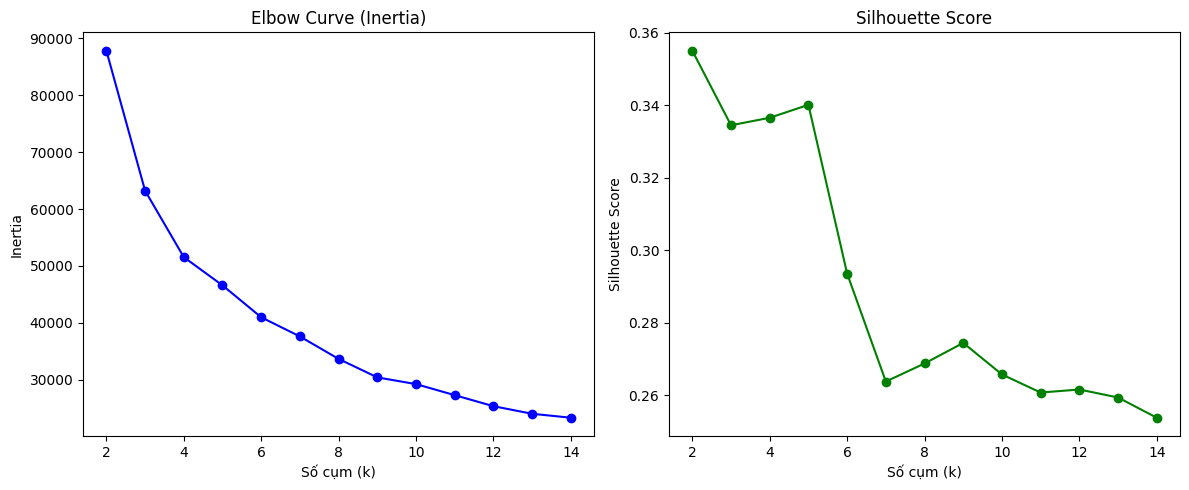

In [21]:
# 1. Lựa chọn đặc trưng
selected_features = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Time_taken(min)']
features_df = df[selected_features].dropna()  # Bỏ các dòng chứa giá trị thiếu

# 2. Chuẩn hóa dữ liệu
X = StandardScaler().fit_transform(features_df)

# 3. Thử các số cụm từ 2 đến 14
cluster_range = range(2, 15)
inertia_values = []
silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# 4. Vẽ biểu đồ Elbow và Silhouette
plt.figure(figsize=(12, 5))

# Elbow Curve
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_values, marker='o', color='blue')
plt.title('Elbow Curve (Inertia)')
plt.xlabel('Số cụm (k)')
plt.ylabel('Inertia')

# Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('Số cụm (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

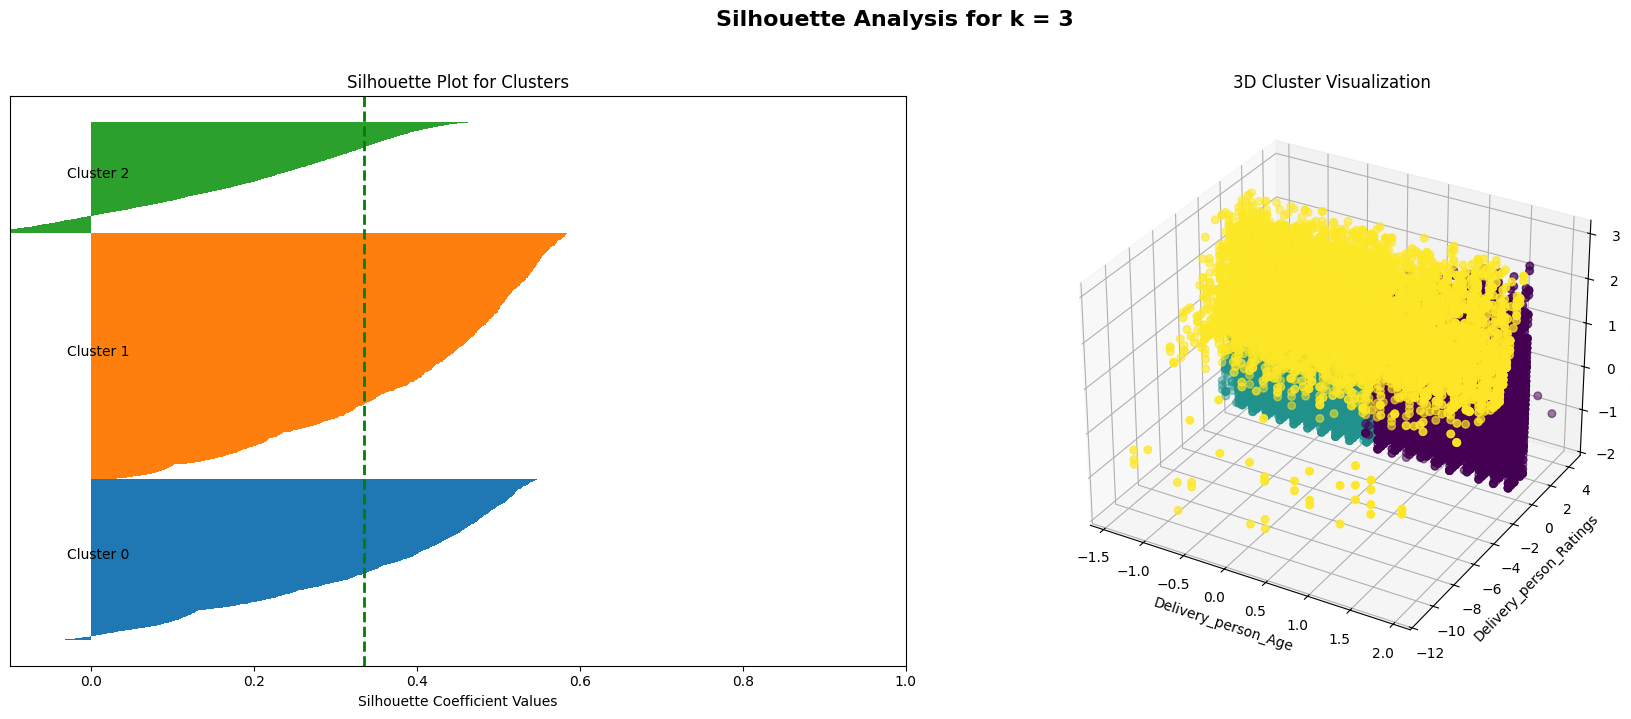

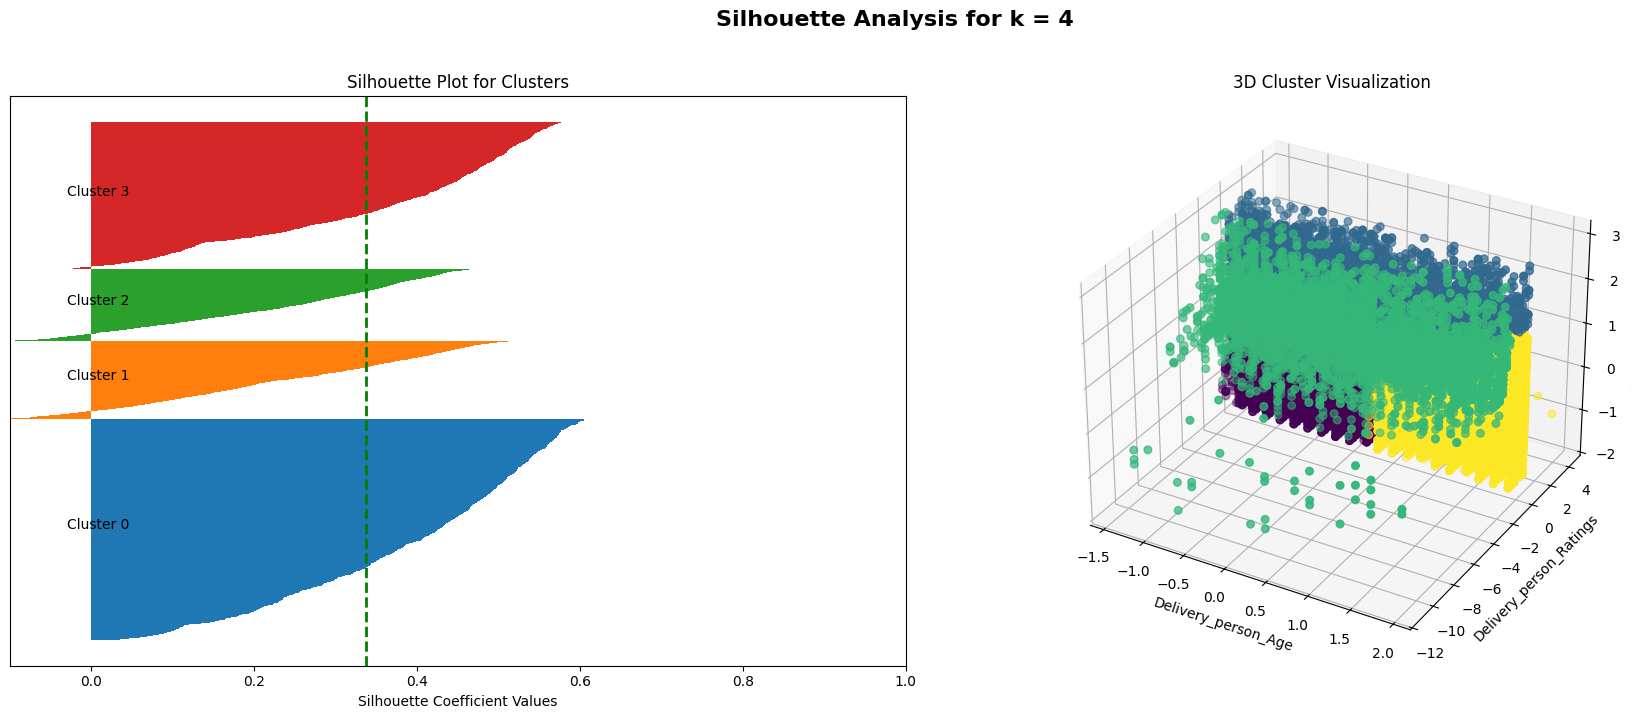

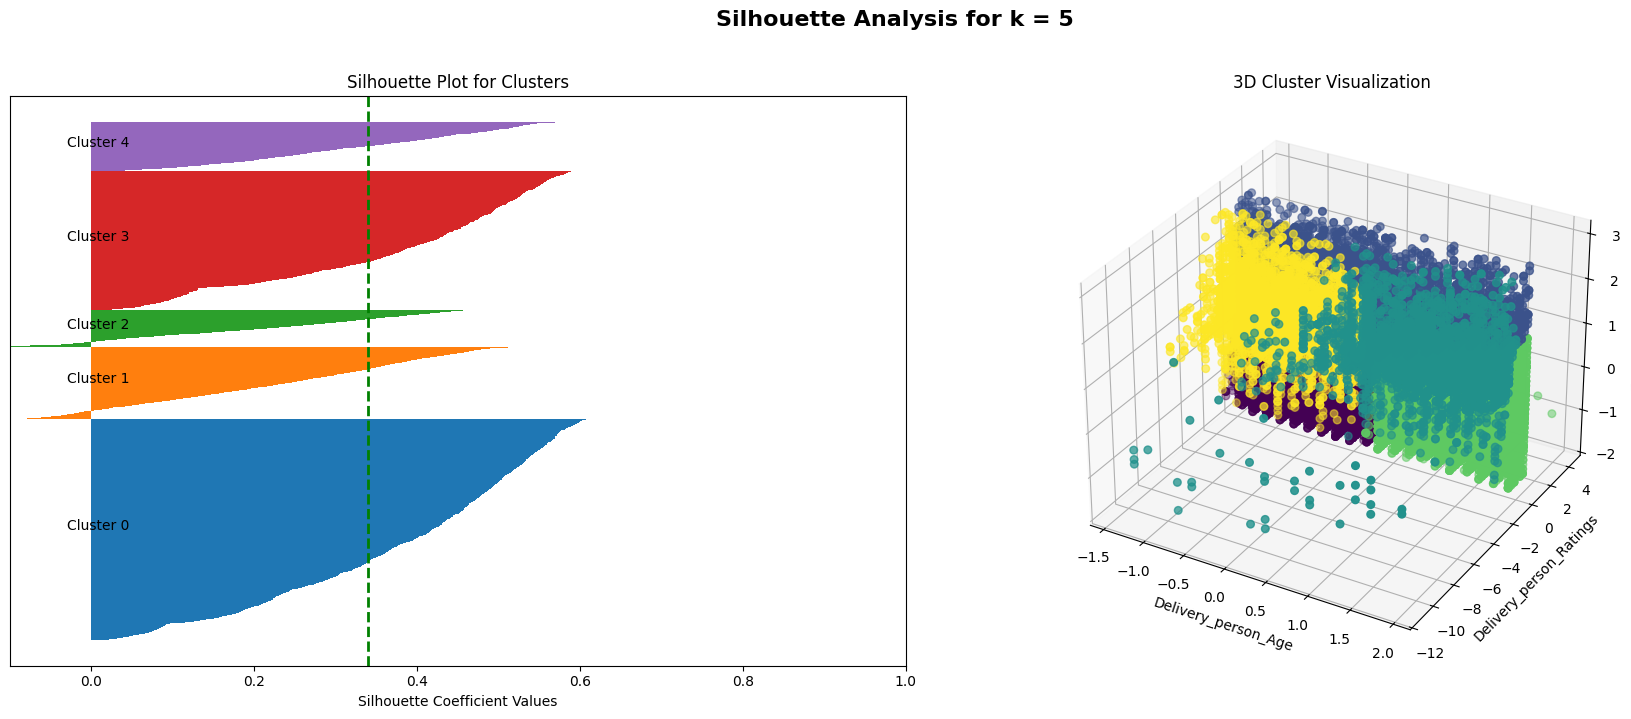

In [22]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_samples

# 1. Lựa chọn và chuẩn hóa dữ liệu
selected_features = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Time_taken(min)']
features_df = df[selected_features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df)

# 2. Phân cụm và vẽ biểu đồ cho k = 3, 4, 5
for k in [3, 4, 5]:
    fig = plt.figure(figsize=(18, 7))

    # KMeans clustering
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    centroids = km.cluster_centers_

    # Silhouette values
    silhouette_vals = silhouette_samples(X_scaled, labels)

    # Silhouette plot
    ax1 = fig.add_subplot(121)
    y_lower = 0
    for cluster in np.unique(labels):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper = y_lower + len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, f'Cluster {cluster}')
        y_lower = y_upper

    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette Coefficient Values')
    ax1.set_title('Silhouette Plot for Clusters')

    # 3D Scatter plot
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=labels, cmap='viridis', s=30)
    ax2.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='*', c='red', s=250)
    ax2.set_xlabel('Delivery_person_Age')
    ax2.set_ylabel('Delivery_person_Ratings')
    ax2.set_zlabel('Time_taken(min)')
    ax2.set_title('3D Cluster Visualization')

    plt.suptitle(f'Silhouette Analysis for k = {k}', fontsize=16, fontweight='semibold', y=1.02)
    plt.tight_layout()
    plt.show()


In [23]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# 1. Lựa chọn và chuẩn hóa đặc trưng
selected_features = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Time_taken(min)']
features_df = df[selected_features].dropna()  # Bỏ các dòng có giá trị thiếu

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df)

# 2. Phân cụm KMeans
k = 5
kmeans_model = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans_model.fit_predict(X_scaled)

# 3. Tạo DataFrame chứa nhãn cụm
person_cluster_df = features_df.copy()
person_cluster_df['cluster'] = cluster_labels

# 4. Thống kê số lượng phần tử trong mỗi cụm
print("Số lượng phần tử trong mỗi cụm:")
print(person_cluster_df['cluster'].value_counts())

# 5. Các chỉ số đánh giá chất lượng phân cụm:

# WSS (Within-Cluster Sum of Squares) - Càng nhỏ càng tốt
wss = kmeans_model.inertia_
print("Within-Cluster Sum of Squares (WSS):", wss)

# BSS (Between-Cluster Sum of Squares)
centroids = kmeans_model.cluster_centers_
mean = features_df.mean(axis=0)  # Tính giá trị trung bình của các đặc trưng
cluster_sizes = np.bincount(cluster_labels)
bss = np.sum(cluster_sizes[:, np.newaxis] * (centroids - mean.values) ** 2)
print("Between-Cluster Sum of Squares (BSS):", bss)

# Silhouette Score (Điểm càng gần 1 càng tốt, càng gần -1 càng tệ)
sil_avg = silhouette_score(X_scaled, cluster_labels)
print("Silhouette Score:", sil_avg)

# Calinski Harabasz Score (Điểm cao hơn cho thấy phân cụm tốt hơn)
calinski_harabasz_score_val = calinski_harabasz_score(X_scaled, cluster_labels)
print("Calinski Harabasz Score:", calinski_harabasz_score_val)


Số lượng phần tử trong mỗi cụm:
cluster
0    17858
3    11218
1     5846
4     3988
2     2991
Name: count, dtype: int64
Within-Cluster Sum of Squares (WSS): 46586.48016224075
Between-Cluster Sum of Squares (BSS): 62851210.34477155
Silhouette Score: 0.3401419538409978
Calinski Harabasz Score: 17787.765175970962


In [24]:
person_cluster_df.groupby("cluster")
person_cluster_df.head(20)

Delivery_person_Age  Delivery_person_Ratings  Time_taken(min)  cluster
0                    37                      4.9               24        3
1                    21                      4.5               33        4
2                    23                      4.4               26        0
3                    24                      4.7               21        0
4                    20                      4.6               30        0
5                    21                      4.8               26        0
6                    28                      4.7               40        1
7                    30                      4.6               32        1
8                    22                      4.8               34        1
9                    22                      4.2               46        4
10                   34                      4.7               23        3
11                   26                      4.7               21        0
12                   20                      4.3               20        0
13                   37                      4.7               41        1
14                   26                      4.5               20        0
15                   23                      4.0               33        4
16                   28                      4.2               40        4
17                   24                      4.9               41        1
18                   21                      4.7               15        0
19                   23                      4.1               36        4

**Phân bổ cụm**

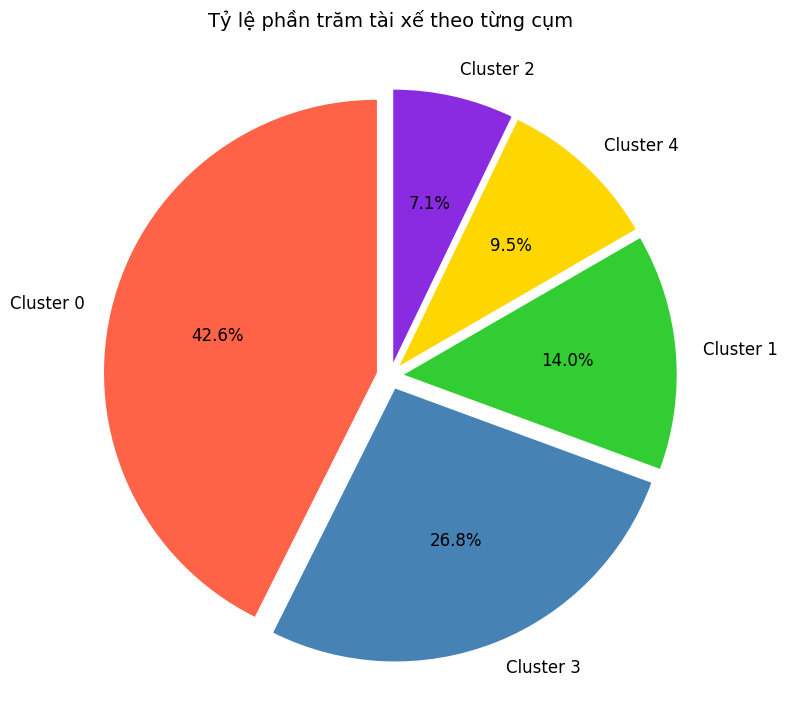

In [25]:
# Tính tỷ lệ phần trăm số lượng tài xế trong từng cụm
cluster_counts = person_cluster_df['cluster'].value_counts(normalize=True) * 100  # Đổi sang %

# Vẽ biểu đồ tròn
fig, ax = plt.subplots(figsize=(8, 8))
colors = ['#FF6347', '#4682B4', '#32CD32', '#FFD700', '#8A2BE2']  # Màu sắc cho 5 cụm (hoặc tự động mở rộng)
explode = [0.05] * len(cluster_counts)  # Tách nhẹ các phần của biểu đồ

ax.pie(
    cluster_counts.values,
    labels=[f'Cluster {int(idx)}' for idx in cluster_counts.index],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors[:len(cluster_counts)],  # Cắt đúng số màu theo số cụm
    explode=explode,
    textprops={'fontsize': 12}
)

# Tiêu đề
ax.set_title('Tỷ lệ phần trăm tài xế theo từng cụm', fontsize=14)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13068\2892524811.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=person_cluster_df, x='cluster', y=feature, palette='pastel')


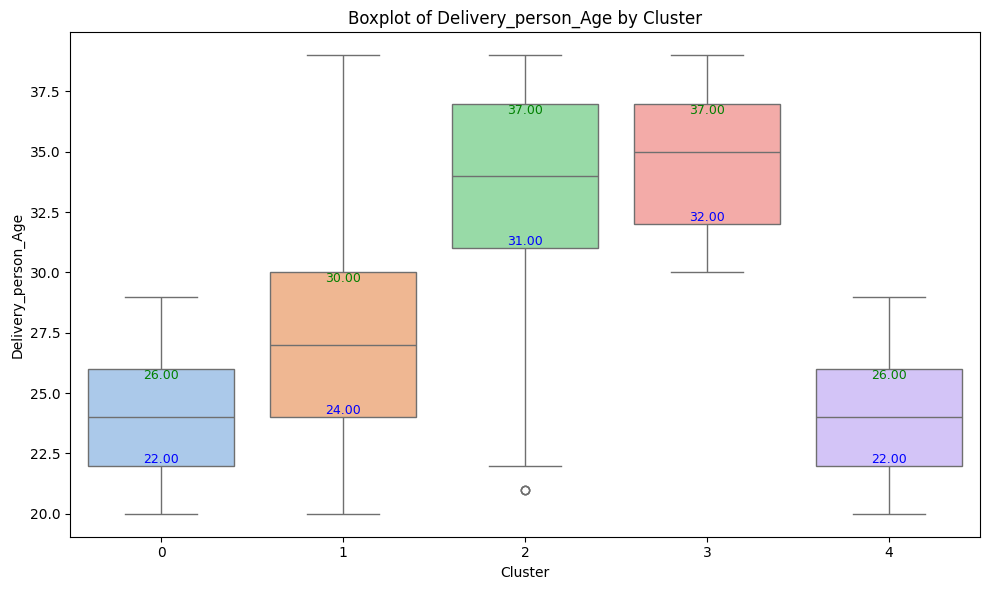

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13068\2892524811.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=person_cluster_df, x='cluster', y=feature, palette='pastel')


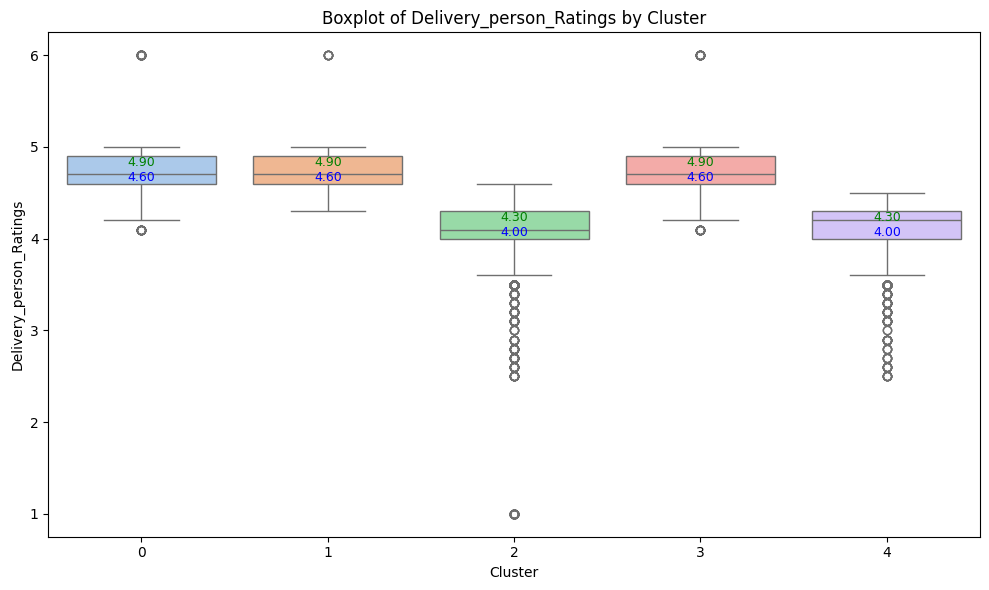

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13068\2892524811.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=person_cluster_df, x='cluster', y=feature, palette='pastel')


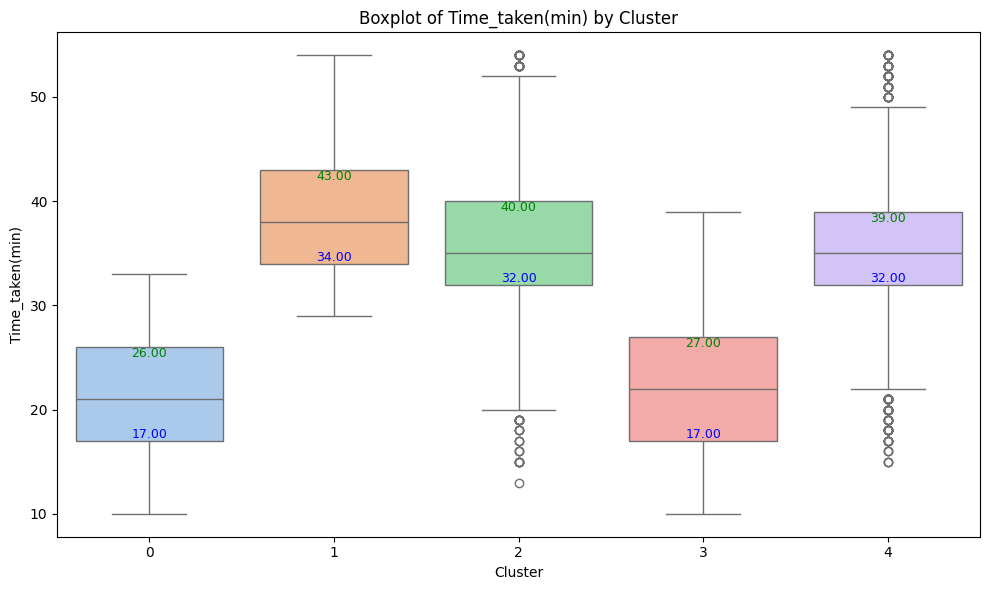

In [26]:
# Danh sách các feature cần vẽ boxplot
features = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Time_taken(min)']

# Duyệt qua từng feature
for feature in features:
    plt.figure(figsize=(10, 6))

    # Vẽ boxplot cho mỗi feature theo từng cluster
    ax = sns.boxplot(data=person_cluster_df, x='cluster', y=feature, palette='pastel')

    # Tiêu đề và nhãn
    plt.title(f'Boxplot of {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)

    # Thêm nhãn cho Q1 và Q3 vào từng cụm
    clusters = sorted(person_cluster_df['cluster'].unique())
    for i, cluster in enumerate(clusters):
        stats = person_cluster_df[person_cluster_df['cluster'] == cluster][feature].describe()
        q1 = stats['25%']
        q3 = stats['75%']
        ax.text(i, q1, f"{q1:.2f}", ha="center", va="bottom", fontsize=9, color='blue')
        ax.text(i, q3, f"{q3:.2f}", ha="center", va="top", fontsize=9, color='green')

    plt.tight_layout()
    plt.show()


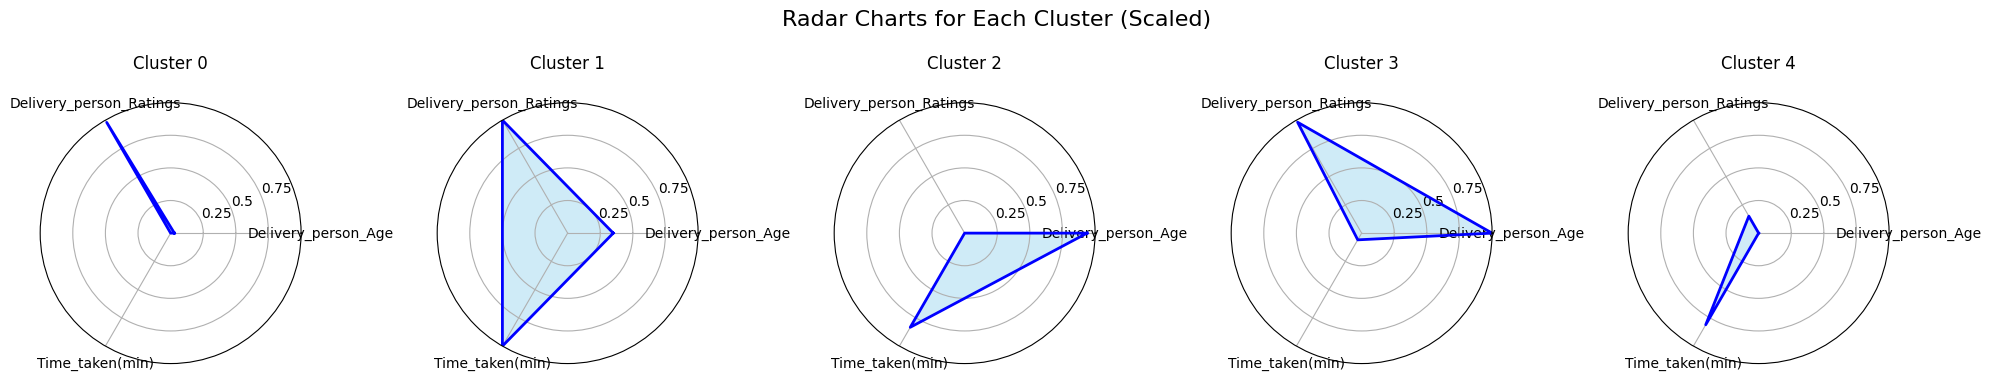

In [27]:
# 1. Tính trung bình theo từng cụm
cluster_means = person_cluster_df.groupby('cluster').mean()

# 2. Chuẩn bị thông tin cho radar chart
categories = selected_features
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # Đóng vòng tròn

# 3. Normalize dữ liệu để biểu đồ các cụm dùng cùng scale (0–1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cluster_means_scaled = scaler.fit_transform(cluster_means)  # scale từng cột 0–1

# 4. Vẽ radar chart từng cụm
fig, axs = plt.subplots(1, k, subplot_kw=dict(polar=True), figsize=(4*k, 4))

if k == 1:
    axs = [axs]  # Đảm bảo luôn là list nếu k=1

for i in range(k):
    values = cluster_means_scaled[i].tolist()
    values += values[:1]  # Đóng vòng tròn

    ax = axs[i]
    ax.plot(angles, values, color='b', linewidth=2)
    ax.fill(angles, values, color='skyblue', alpha=0.4)
    ax.set_title(f'Cluster {i}', size=12, y=1.1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_yticks([0.25, 0.5, 0.75])
    ax.set_yticklabels(["0.25", "0.5", "0.75"])
    ax.set_ylim(0, 1)

plt.suptitle('Radar Charts for Each Cluster (Scaled)', fontsize=16)
plt.tight_layout()
plt.show()


In [28]:
#lưu mô hình đã xử lý
import joblib
# Lưu mô hình KMeans
joblib.dump(kmeans_model, 'kmeans_model.pkl')
# Lưu scaler
joblib.dump(scaler, 'scaler.pkl')
# Lưu DataFrame chứa nhãn cụm
person_cluster_df.to_csv('person_cluster_df.csv', index=False)